In [2]:
import glob
import cv2
import random
import re
import matplotlib.pyplot as plt
import numpy as np

In [3]:
images=glob.glob("data\*.jpg")
iimages=sorted(images, key=lambda s:int(re.search(r'\d+',s).group()))

In [4]:
im0=cv2.imread(iimages[191])
im1=cv2.imread(iimages[192])
im2=cv2.imread(iimages[193])

In [18]:
sift=cv2.SIFT_create(5000)
k1,d1= sift.detectAndCompute(im1,None)
k2,d2= sift.detectAndCompute(im2,None)

matcher= cv2.BFMatcher()
matches= matcher.knnMatch(d1,d2,k=2)

good=[]
for m,n in matches:
    if m.distance<0.75*n.distance:
        good.append(m)

src=np.float32([k1[m.queryIdx].pt for m in good]).reshape(-1,1,2)
dst=np.float32([k2[m.trainIdx].pt for m in good]).reshape(-1,1,2)

H, _= cv2.findHomography(src,dst,cv2.RANSAC, 5.0)

In [ ]:
len(good)

323


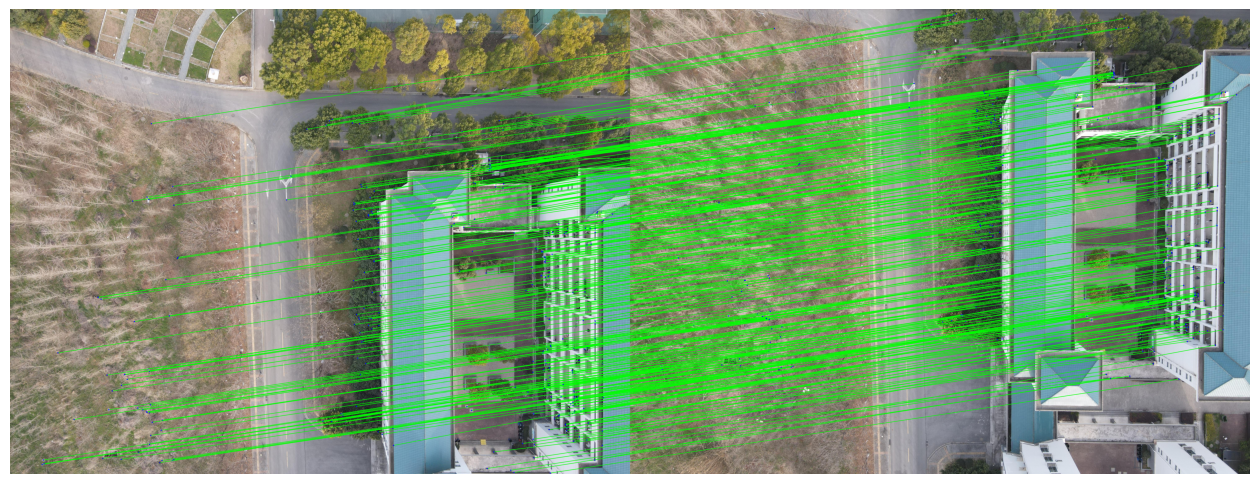

In [13]:
match_img = cv2.drawMatches(im1, k1, im2, k2, best, None,
                                    matchesMask=None,
                                    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
h1, w1 = im1.shape[:2]
for i, m in enumerate(best):
    
    pt1 = tuple(np.round(k1[m.queryIdx].pt).astype(int))
    pt2 = tuple(np.round(k2[m.trainIdx].pt).astype(int))
    pt2_shifted = (int(pt2[0] + w1), int(pt2[1]))  # car concaténation horizontale

    cv2.line(match_img, pt1, pt2_shifted, (0,255,0), thickness=2, lineType=cv2.LINE_AA)
    cv2.circle(match_img, pt1, 4, (255,0,0), -1)
    cv2.circle(match_img, pt2_shifted, 4, (255,0,0), -1)

plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [19]:
h1, w1 = im1.shape[:2]

# Coins de l'image source
corners = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)

# Appliquer l'homographie aux coins
transformed_corners = cv2.perspectiveTransform(corners, H)
[x_min, y_min] = np.int32(transformed_corners.min(axis=0).ravel() - 0.5)
[x_max, y_max] = np.int32(transformed_corners.max(axis=0).ravel() + 0.5)

# Calcul du décalage pour éviter les coordonnées négatives
translation = [-x_min, -y_min]

# Matrice de translation à appliquer après l'homographie
T = np.array([
    [1, 0, translation[0]],
    [0, 1, translation[1]],
    [0, 0, 1]
])
warped_full = cv2.warpPerspective(im1, T @ H, (x_max - x_min, y_max - y_min))

In [20]:
distances=[]
points=[]
for g in good:
    q=g.queryIdx
    t=g.trainIdx
    pos1=np.round(k1[q].pt).astype(int)
    pos2=np.round(k2[t].pt).astype(int)
    #print(pos1,pos2)
    points.append((pos1,pos2))
    dist=np.sqrt((pos1[0]-pos2[0])**2+(pos1[1]-pos2[1])**2)
    distances.append(dist)
res=np.mean(distances)
print(res)
pts=np.array(points)
min_idx1=np.argmin(pts[:,1,1])
l1=pts[min_idx1][0,1]
max_idx1=np.argmax(pts[:,0,1])
l2=pts[max_idx1][1,1]
# pt=pts[min_idx]
# dist_pt=np.sqrt((pt[0][0]-pt[1][0])**2+(pt[0][1]-pt[1][1])**2)
#Attention, il faudras vérifier que les distances ne sont pas trop éloignés de la distance moyenne sinon ça veut dire que c'est un mauvais keypoint
#(+-10% de la valeure initiale je pense)
print(res)

630.4788692240855
630.4788692240855


In [21]:
im_out=cv2.warpPerspective(im1,H,(w1,h1))

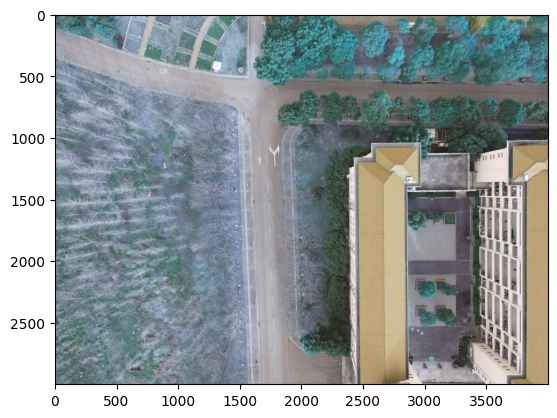

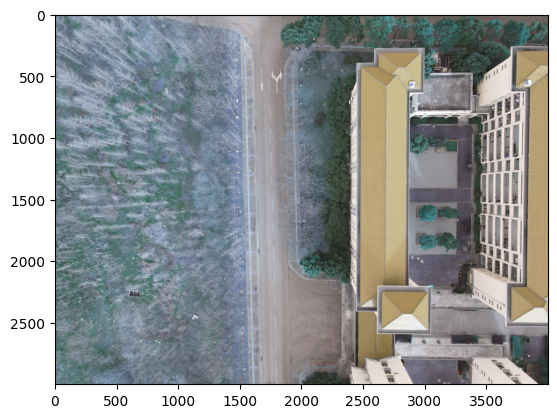

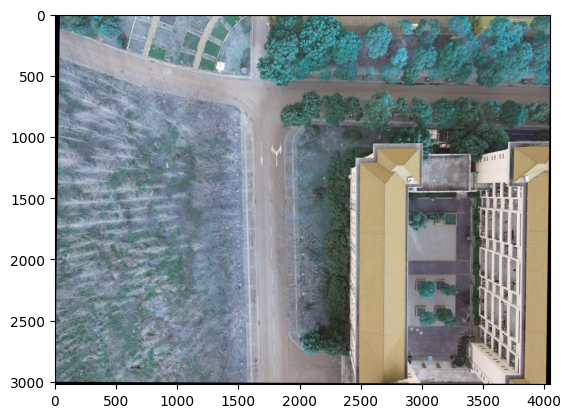

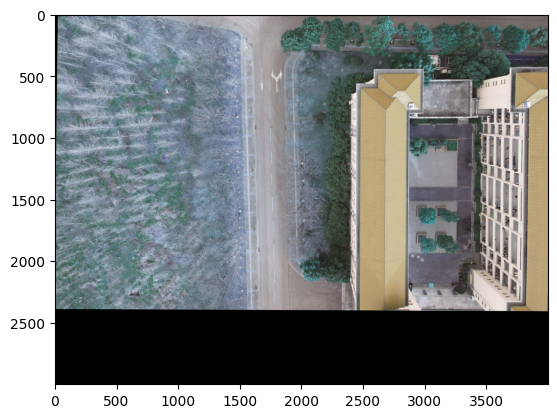

In [ ]:
plt.imshow(im1)
plt.show()
plt.imshow(im2)
plt.show()
plt.imshow(warped_full)
plt.show()


In [31]:
# Coins de im1 et im2 dans l'espace du canevas final
h2, w2 = im2.shape[:2]
corners1 = cv2.perspectiveTransform(np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2), T @ H)
# corners2 = np.float32([[translation[0], translation[1]],
#                        [translation[0], translation[1]+h2],
#                        [translation[0]+w2, translation[1]+h2],
#                        [translation[0]+w2, translation[1]]]).reshape(-1, 1, 2)
corners2 = np.float32([[0, 0],
                       [0, h2],
                       [w2, h2],
                       [w2, 0]]).reshape(-1, 1, 2)

In [32]:
# Bounding box 1
x1_min, y1_min = corners1.min(axis=0).ravel()
x1_max, y1_max = corners1.max(axis=0).ravel()

# Bounding box 2
x2_min, y2_min = corners2.min(axis=0).ravel()
x2_max, y2_max = corners2.max(axis=0).ravel()

# Intersection de leurs bounding boxes
x_overlap_min = int(max(x1_min, x2_min))
x_overlap_max = int(min(x1_max, x2_max))
y_overlap_min = int(max(y1_min, y2_min))
y_overlap_max = int(min(y1_max, y2_max))


In [33]:
print(x_overlap_max,x_overlap_min,y_overlap_max,y_overlap_min)

4000 0 3000 0


In [34]:
# Extraire les régions de recouvrement (tu peux les redimensionner ou interpoler)
overlap_region1 = warped_full[y_overlap_min:y_overlap_max, x_overlap_min:x_overlap_max]
overlap_region2 = im2[y_overlap_min:y_overlap_max, x_overlap_min:x_overlap_max]


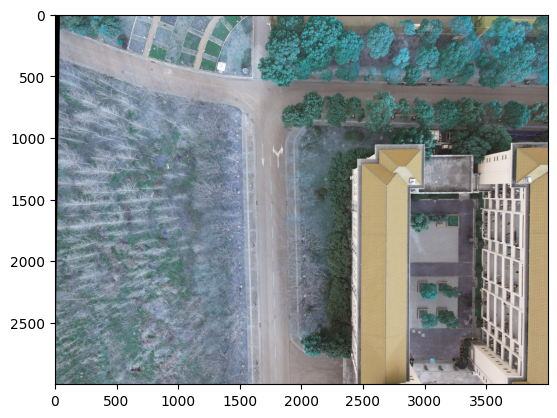

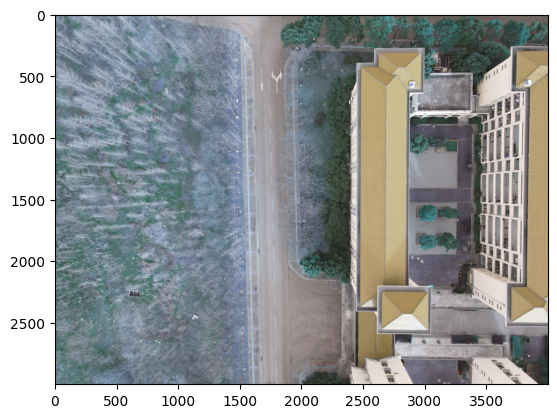

In [35]:
plt.imshow(overlap_region1)
plt.show()
plt.imshow(overlap_region2)
plt.show()

In [12]:
h1, w1=im1.shape[:2]
h2,w2=im2.shape[:2]
corners=np.array([[0,0],[0,h2],[w2,h2],[w2,0]])
warped_corn=cv2.perspectiveTransform(np.float32([corners]),H)

# x_min= int(max(0,min(warped_corn[:,0])))
# x_max= int(min(w1,max(warped_corn[:,0])))

# y_min= int(max(0,min(warped_corn[:,1])))
# y_max= int(min(h1,max(warped_corn[:,1])))

In [20]:
warped_corn

array([[[-303.2657 ,  763.90344],
        [-539.48486, 4148.261  ],
        [3999.9575 , 2184.6824 ],
        [4037.6003 , -753.00214]]], dtype=float32)

In [12]:
print(x_min,x_max,y_min,y_max)

0 4000 0 3000


In [13]:
warped_corn

array([[-303.2657 ,  763.90344],
       [-539.48486, 4148.261  ],
       [3999.9575 , 2184.6824 ],
       [4037.6003 , -753.00214]], dtype=float32)

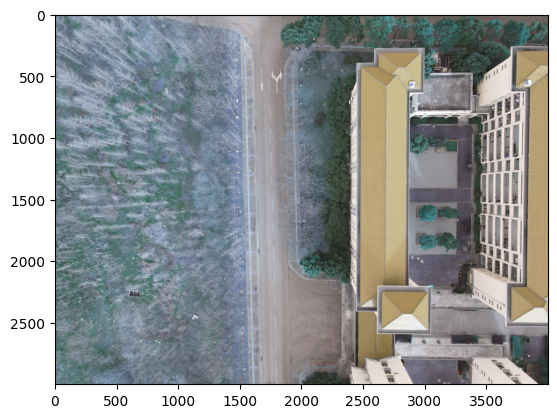

In [6]:
plt.imshow(im2)
plt.show()